<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Hallucination Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting hallucinations,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.experimental.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include "halueval_qa_data" from the HaluEval benchmark:

- https://arxiv.org/abs/2305.11747
- https://github.com/RUCAIBox/HaluEval

In [5]:
df = download_benchmark_dataset(
    task="binary-hallucination-classification", dataset_name="halueval_qa_data"
)
df.head()

,reference,query,response,is_hallucination
0,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,no,False
1,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,"Yes, Fuyang and Gaozhou are in the same province.",True
2,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"Billboard"" Hot 100",False
3,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"""808"" peaked at number nine on ""Billboard"" Hot 100.",True
4,"""Arms"" then made a comeback in 2017 reaching #36 on the iTunes chart passing Auli'i Cravalho's ""How Far I'll Go"" from the Disney movie ""Moana"" (2017).Moana ( ) is a 2016 American 3D computer-animated musical fantasy-adventure film produced by Walt Disney Animation Studios and released by Walt Disney Pictures.","Arms is a song by American singer-songwriter Christina Perri, in 2017, it passed Auli'i Cravalho's, ""How Far I'll Go"" from which 2016, American 3D computer-animated Disney movie?",Moana,False


## Display Binary Hallucination Classification Template

View the default template used to classify hallucinations. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(HALLUCINATION_PROMPT_TEMPLATE)


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text. Your response should be a single word: either "factual" or "hallucinated", and
it should not include any other text or characters. "hallucinated" indicates that the answer
provides factually inaccurate information to the query based on the reference text. "factual"
indicates that the answer to the question is correct relative to the reference text, and does not
contain made up inf

Template variables:
- **input** : The question or prompt asked on the context data.
- **reference** : The context data used to answer the question
- **output** : The answer generated from the context data, we are checking this answer for halluciations relative to the reference context

## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df = (
    df.sample(n=N_EVAL_SAMPLE_SIZE)
    .reset_index(drop=True)
    .rename(columns={"query": "input", "response": "output"})
)

## LLM Evals: hallucination Classifications GPT-4
Run hallucination against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [10]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [11]:
# The rails fore the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails, concurrency=20
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s



Evaluate the predictions against human-labeled ground-truth hallucination labels.

              precision    recall  f1-score   support

hallucinated       0.84      0.76      0.80        49
     factual       0.79      0.86      0.82        51

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

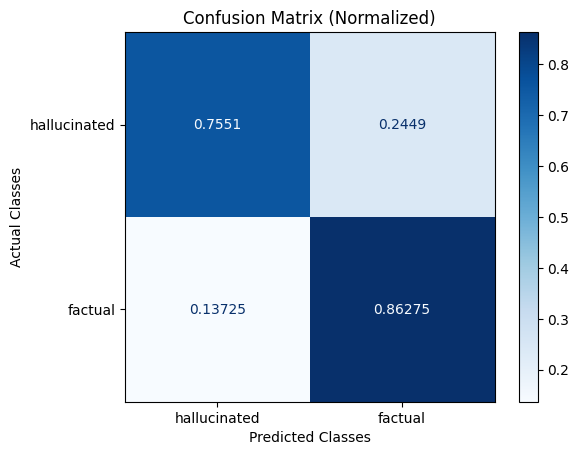

In [12]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for hallucinations, it can be useful to know why the LLM classified a response as a hallucination or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [13]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
hallucination_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text.

    [BEGIN DATA]
    ************
    [Query]: {input}
    ************
    [Reference text]: {reference}
    ************
    [Answer]: {output}
    ************
    [END DATA]

    Is the answer above factual or hallucinated based on the query and reference text?

Please read the query, reference text and answer carefully, then write out in a step by step manner


llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'factual' to rail: factual
- Snapped 'factual' to rail: factual
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'hallucinated' to rail: hallucinated


In [14]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, hallucination_classifications_df, left_index=True, right_index=True
)
merged_df[["input", "reference", "output", "is_hallucination", "label", "explanation"]].head()

,input,reference,output,is_hallucination,label,explanation
0,Which of the two were founded first out of Syracuse University and University of Washington?,"Syracuse University (commonly referred to as Syracuse, 'Cuse, or SU) is a private research university in Syracuse, New York, United States. The institution's roots can be traced to the Genesee Wesleyan Seminary (later becoming Genesee College), founded in 1831 by the Methodist Episcopal Church in Lima, New York.The University of Washington (commonly referred to as UW, simply Washington, or informally ""U-Dub"") is a large, public flagship research university in Seattle, Washington, established in 1861.",The University of Washington was founded first.,True,hallucinated,"The reference text states that Syracuse University was founded in 1831 and the University of Washington was established in 1861. Therefore, Syracuse University was founded first, not the University of Washington as stated in the answer. The answer is not consistent with the information provided in the reference text."
1,Troublemakers was the last Western in which Bud Spencer paired with which longtime collaborator?,"It is the last pairing of Terence Hill (who also directed) and Bud Spencer.Carlo Pedersoli (31 October 1929 – 27 June 2016), professionally known as Bud Spencer, was an Italian actor, professional swimmer and water polo player.",Troublemakers was the last Western in which Bud Spencer paired with actor Terence Hill onscreen.,True,factual,"The query asks for the longtime collaborator with whom Bud Spencer paired in his last Western, Troublemakers. The reference text clearly states that 'It is the last pairing of Terence Hill (who also directed) and Bud Spencer.' The answer provided, 'Troublemakers was the last Western in which Bud Spencer paired with actor Terence Hill onscreen,' is in line with the information given in the reference text. Therefore, the answer is factual."
2,"Who is older, Rohan Bopanna or Sherwood Stewart?","Rohan Bopanna (born 4 March 1980) is an Indian professional tennis player.Sherwood Stewart (born June 6, 1946, in Goose Creek, Texas, United States) played amateur and professional tennis in the 1970s and 1980s.",Sherwood Stewart,False,factual,"The query asks who is older between Rohan Bopanna and Sherwood Stewart. The reference text provides the birth dates for both individuals: Rohan Bopanna was born on 4 March 1980 and Sherwood Stewart was born on June 6, 1946. By comparing these dates, it is clear that Sherwood Stewart is older than Rohan Bopanna. Therefore, the answer 'Sherwood Stewart' is correct and based on the information provided in the reference text."
3,"What was the name of the band that starred Belinda Carlisle and released the album, Germicide in 1977?","Disc jockey Rodney Bingenheimer appears at the beginning as master of ceremonies, and ""Belinda"" briefly takes the mic to introduce the band, who she describes as ""sluts"". She gained worldwide fame as the lead vocalist of The Go-Go's, one of the most successful all-female bands of all time, and went on to have a prolific career as a solo act.",Belinda Carlisleís band released Germicide.,True,hallucinated,"The query asks for the name of the band that Belinda Carlisle was a part of and that released the album 'Germicide' in 1977. The reference text mentions that Belinda Carlisle was the lead vocalist of The Go-Go's, but it does not mention the album 'Germicide' or the year 1977. Therefore, the answer assumes information that is not available in the reference text."
4,What series does the American character actor best-known for playing General Hammond star in the first episode?,"""Episode 8"", also known as ""May the Giant Be with You"", is the first episode of the second season of the American mystery television series ""Twin Peaks"".Don Sinclair Davis, PhD (August 4, 1942 – June 29, 2008) was an American character actor best-known for playing General Hammond in the television series ""Stargate SG-1"" (1997–2007

## LLM Evals: hallucination Classifications GPT-3.5
Run hallucination against a subset of the data.

In [15]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [16]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails, concurrency=20
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

hallucinated       0.97      0.73      0.84        49
     factual       0.79      0.98      0.88        51

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.86       100
weighted avg       0.88      0.86      0.86       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

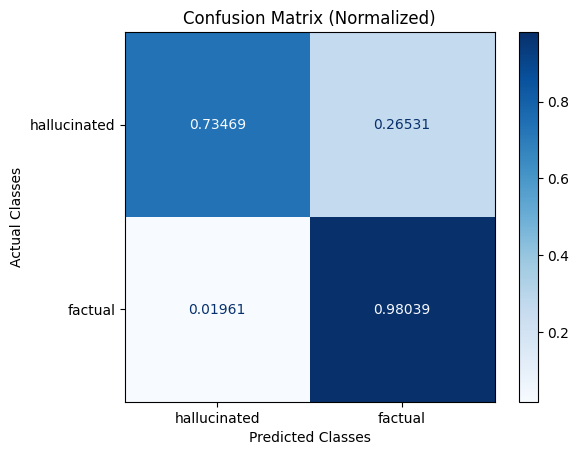

In [17]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [18]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=OpenAIModel(model_name="gpt-4-turbo-preview", temperature=0.0),
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

hallucinated       0.89      0.80      0.84        49
     factual       0.82      0.90      0.86        51

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

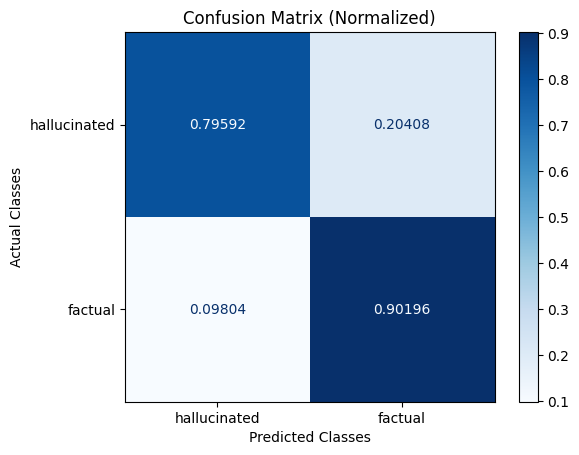

In [19]:
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)